In [1]:
import bambi as bmb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import csv
from collections import defaultdict
from IPython.display import display
from scipy import stats
import pymc as py
import arviz as az
import json

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#inverted , which is needed for some of the presence quetsionaires ( 8-, since  a likert scale of 7 was used)
def invert(d):
    return 8-d
computer = "C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis"
#computer = "C:/Users/LauflaborVR2/GS-MT_Test"
soci_data = pd.read_csv(computer +"/Data/main_presence_questionaire.csv")
heights = soci_data["Height"]
weights = soci_data["Weight"]
demographic_labels = ["Gender", "Age", "Height", "Weight"]
vr_labels = ["VR Experience","VR Usage","First Person Video Games", "Motion Sickness"]
demo_data = soci_data[demographic_labels]
vr_data = soci_data[vr_labels]
ipq_data = soci_data.drop(demographic_labels + vr_labels, axis= 1)
ipq11 = ipq_data.drop( "VPID", axis=1)
ipq11[["Presence 6: How real did the virtual world seem to you?","Presence 7: How aware were you of the real world surrounding while navigating in the virtual world? (i.e. sounds, room temperature, other people, etc.)?" ]]= ipq11[["Presence 6: How real did the virtual world seem to you?","Presence 7: How aware were you of the real world surrounding while navigating in the virtual world? (i.e. sounds, room temperature, other people, etc.)?" ]].map(invert)
ipq_means = ipq11.mean(axis=1)


In [15]:
with open('combined_step_analysis_results_with_arrays.json', 'r') as file:
    data = json.load(file)

# Flatten JSON into a structured DataFrame
flat_data = []

for participant, conditions in data.items():
    for condition, trials in conditions.items():
        for trial, metrics in trials.items():
            # Extract only the required scalar value for velocity (assuming velocity_mean_l is a float, not a list)
            if isinstance(metrics["mean_velocity"], list):
                # If velocity_mean_l is somehow a list, take the mean or handle appropriately
                velocity = sum(metrics["mean_velocity"]) / len(metrics["mean_velocity"])
            else:
                velocity = metrics["mean_velocity"]
            """ "RoM_ankle_l": metrics["footAngle_l"],
                "RoM_knee_l": metrics["kneeAngle_l"],
                "RoM_ankle_r": metrics["footAngle_r"],
                "RoM_knee_r": metrics["kneeAngle_r"], """
            row = {
                "Participant": participant,
                "Condition": condition,
                "Trial": trial,
                "Velocity": velocity, 
                "numStrides_r": metrics["numStrides_r"],
                "numStrides_l": metrics["numStrides_l"],
                "Walking_distance": metrics["walking_distance_r"],
                "HeelR_velocity": metrics["HeelR_velocity"],
                "HeelL_velocity": metrics["HeelL_velocity"],
                "strideLength_r": metrics["meanstrideLength_r"],
                "strideLength_l": metrics["meanstrideLength_l"],

            }
            flat_data.append(row)

# Create a pandas DataFrame
df = pd.DataFrame(flat_data)

df['Participant'] = df['Participant'].str.extract('(\d+)').astype(int)
df['Condition'] = df['Condition'].str.extract('(\d+)').astype(int)
df['Trial'] = df['Trial'].str.extract('(\d+)').astype(int)
# Convert categorical variables
df['Participant'] = df['Participant'].astype('category')
df['Condition'] = df['Condition'].astype('category')

#normalize velocity
velocity_min = df['Velocity'].min()
velocity_max = df['Velocity'].max()

# Min-Max Normalisierung der Velocity-Daten
df['Velocity_normalized'] = (df['Velocity'] - velocity_min) / (velocity_max - velocity_min)

unique_participants = df['Participant'].unique()
participant_height_dict = dict(zip(unique_participants, heights))
df["Height"] = df["Participant"].map(participant_height_dict)
participant_weight_dict = dict(zip(unique_participants, weights))
df["Weight"] = df["Participant"].map(participant_weight_dict)
participant_presence_dict = dict(zip(unique_participants, ipq_means))
df['Presence'] = df['Participant'].map(participant_presence_dict)

embodi_data = {}
condition_names =["Baseline", "Large", "NoAvatar", "Normal", "Small"]
for c in df['Condition'].unique():
    if c== 0:
        continue

    temp = {}
    cond = condition_names[c-1]
    for p in df['Participant'].unique():
        if p< 10:
            file_path = computer + f"/Data/0{p}{cond}.csv"
        else:
             file_path =  computer + f"/Data/{p}{cond}.csv"
        try:
            d = pd.read_csv(file_path, names=["Question", "Value"])
            temp[p] = d
        except FileNotFoundError:
            print(f"Datei nicht gefunden: {file_path}")
    embodi_data[c] = temp

# alles auf meter (pro sekunde) bringen 
df['Height'] = df['Height']/100
df['Velocity'] = df['Velocity']/1000
df["Walking_distance"] = df["Walking_distance"]/1000
df["HeelR_velocity"] = df["HeelR_velocity"]/1000
df["HeelL_velocity"] = df["HeelL_velocity"]/1000
df["strideLength_l"] = df["strideLength_l"]/1000
df["strideLength_r"] = df["strideLength_r"]/1000

# Fragebogendaten dem DataFrame df hinzufügen
question_columns = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12']

for index, row in df.iterrows():
    participant = row['Participant']
    condition = row['Condition']

    # Fragebogendaten nur hinzufügen, wenn es sich nicht um die Baseline-Bedingung handelt
    if condition != 0 and condition in embodi_data and participant in embodi_data[condition]:
        survey_data = embodi_data[condition][participant]
        # Berechnung der Mittelwerte für "Ownership", "Agency" und "Change"
        ownership_mean = survey_data['Value'].iloc[:4].mean()
        agency_mean = survey_data['Value'].iloc[4:8].mean()
        change_mean = survey_data['Value'].iloc[8:12].mean()
        
        # Mittelwerte dem DataFrame hinzufügen
        df.at[index, 'Ownership'] = ownership_mean
        df.at[index, 'Agency'] = agency_mean
        df.at[index, 'Change'] = change_mean

Datei nicht gefunden: C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis/Data/08Baseline.csv
Datei nicht gefunden: C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis/Data/09Baseline.csv
Datei nicht gefunden: C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis/Data/10Baseline.csv
Datei nicht gefunden: C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis/Data/11Baseline.csv
Datei nicht gefunden: C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis/Data/12Baseline.csv
Datei nicht gefunden: C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis/Data/13Baseline.csv
Datei nicht gefunden: C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis/Data/14Baseline.csv
Datei nicht gefunden: C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis/Data/15Baseline.csv
Datei nicht gefunden: C:/Users/grego/OneDrive/Dokumente/Uni/MasterThesis/Master_Thesis/Data/16Baseline.csv
Datei nicht gefunden: C:/Users/grego/

In [9]:
df["strideLength_l"]

0      1.079673
1      1.069658
2      1.019258
3      1.289870
4      1.071420
         ...   
443    1.319795
444    1.236168
445    1.700555
446    1.348808
447    1.327207
Name: strideLength_l, Length: 448, dtype: float64

In [ ]:
## Deskriptive analysis

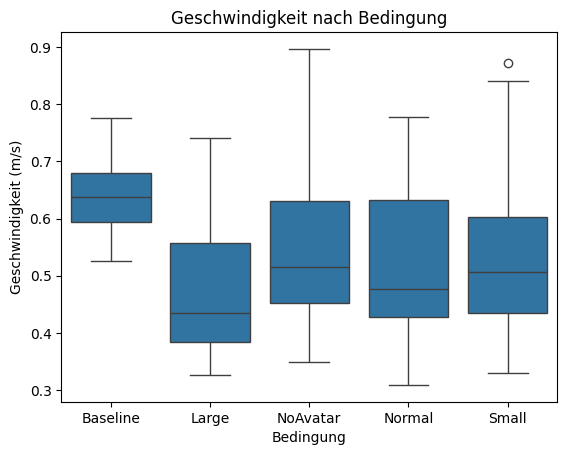

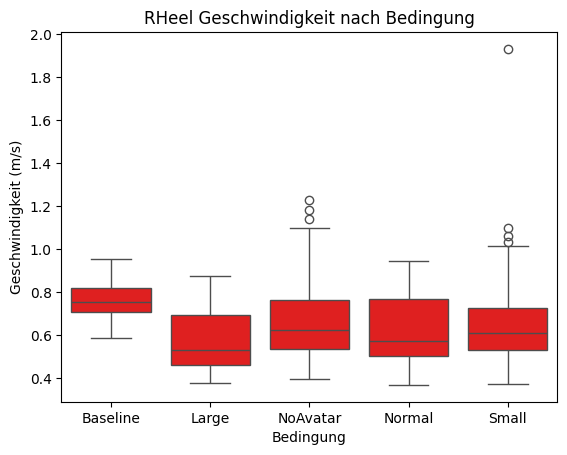

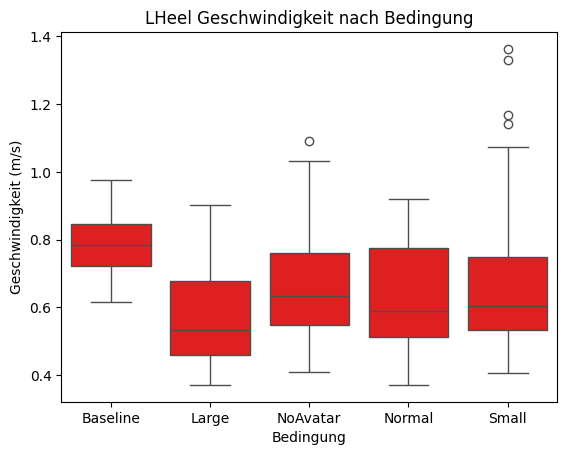

In [ ]:
sns.boxplot(x='Condition', y='Velocity', data=df)
plt.xticks(ticks=range(len(condition_names)), labels=condition_names)
plt.title('Geschwindigkeit nach Bedingung')
plt.xlabel('Bedingung')
plt.ylabel('Geschwindigkeit (m/s)')
plt.show()

""" sns.violinplot(x="Condition", y="Velocity", data=df, inner="quartile")
plt.xticks(ticks=range(len(condition_names)), labels=condition_names)
plt.title("Velocity nach Bedingung (Violinplot)")
plt.xlabel("Bedingung")
plt.ylabel("Geschwindigkeit (m/s)")
plt.show() """

sns.boxplot(x='Condition', y='HeelR_velocity', data=df, color= "r")
plt.xticks(ticks=range(len(condition_names)), labels=condition_names)
plt.title('RHeel Geschwindigkeit nach Bedingung')
plt.xlabel('Bedingung')
plt.ylabel('Geschwindigkeit (m/s)')
plt.show()

sns.boxplot(x='Condition', y='HeelL_velocity', data=df, color= "r")
plt.xticks(ticks=range(len(condition_names)), labels=condition_names)
plt.title('LHeel Geschwindigkeit nach Bedingung')
plt.xlabel('Bedingung')
plt.ylabel('Geschwindigkeit (m/s)')
plt.show()

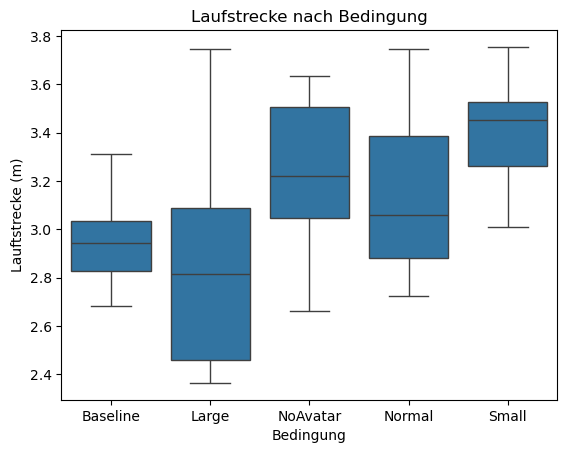

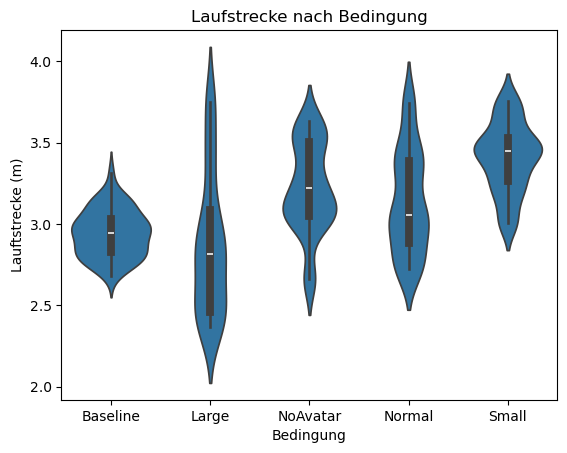

In [25]:
sns.boxplot(x='Condition', y='Walking_distance', data=df)
plt.xticks(ticks=range(len(condition_names)), labels=condition_names)
plt.title('Laufstrecke nach Bedingung')
plt.xlabel('Bedingung')
plt.ylabel('Lauftstrecke (m)')
plt.show()
sns.violinplot(x='Condition', y='Walking_distance', data=df)
plt.xticks(ticks=range(len(condition_names)), labels=condition_names)
plt.title('Laufstrecke nach Bedingung')
plt.xlabel('Bedingung')
plt.ylabel('Lauftstrecke (m)')
plt.show()

In [4]:
# Normalverteilung prüfen
stat, p_value = stats.shapiro(df["Velocity"] )
print("Shapiro-Wilk-Test:", "p-Wert =", p_value)
#nicht normalverteilt

Shapiro-Wilk-Test: p-Wert = 6.0586249774180944e-09


In [ ]:
#Velocity-Daten nach Condition gruppieren
grouped_data = [df[df["Condition"] == condition]["Velocity"] for condition in df["Condition"].unique()]

# Kruskal-Wallis-Test
stat, p_value = stats.kruskal(*grouped_data)

print("Kruskal-Wallis-Test:")
print(f"Teststatistik = {stat}")
print(f"p-Wert = {p_value}")
 #Interpretation
if p_value > 0.05:
    print("Keine signifikanten Unterschiede zwischen den Bedingungen (Nullhypothese nicht abgelehnt).")
else:
    print("Signifikante Unterschiede zwischen den Bedingungen (Nullhypothese abgelehnt).")

Kruskal-Wallis-Test:
Teststatistik = 66.37195768133142
p-Wert = 1.3223929718841714e-13
Signifikante Unterschiede zwischen den Bedingungen (Nullhypothese abgelehnt).


In [18]:
# Paarweise Vergleiche
conditions = df["Condition"].unique()
for i in range(len(conditions)):
    for j in range(i + 1, len(conditions)):
        group1 = df[df["Condition"] == conditions[i]]["Velocity"]
        group2 = df[df["Condition"] == conditions[j]]["Velocity"]
        
        # Mann-Whitney-U-Test
        stat, p_value = stats.mannwhitneyu(group1, group2, alternative="two-sided")
        
        print(f"Mann-Whitney-U-Test zwischen {condition_names[i]} und {condition_names[j]}:")
        print(f"Teststatistik = {stat}, p-Wert = {p_value}")

Mann-Whitney-U-Test zwischen Baseline und Large:
Teststatistik = 4401.0, p-Wert = 3.5422033490672324e-14
Mann-Whitney-U-Test zwischen Baseline und NoAvatar:
Teststatistik = 3813.0, p-Wert = 7.575722837950135e-08
Mann-Whitney-U-Test zwischen Baseline und Normal:
Teststatistik = 3780.0, p-Wert = 3.378192372838261e-07
Mann-Whitney-U-Test zwischen Baseline und Small:
Teststatistik = 3833.0, p-Wert = 4.832786018566112e-08
Mann-Whitney-U-Test zwischen Large und NoAvatar:
Teststatistik = 3239.0, p-Wert = 2.5428787834702683e-05
Mann-Whitney-U-Test zwischen Large und Normal:
Teststatistik = 3705.0, p-Wert = 0.001561700791375623
Mann-Whitney-U-Test zwischen Large und Small:
Teststatistik = 3528.0, p-Wert = 0.00046614718600618776
Mann-Whitney-U-Test zwischen NoAvatar und Normal:
Teststatistik = 5486.0, p-Wert = 0.1873999387882651
Mann-Whitney-U-Test zwischen NoAvatar und Small:
Teststatistik = 5219.0, p-Wert = 0.4302404734937423
Mann-Whitney-U-Test zwischen Normal und Small:
Teststatistik = 4696.

In [6]:
velocity_stats = df.groupby(['Participant', 'Condition'])['Velocity'].agg(['mean', 'std', 'count'])
print(velocity_stats)

                           mean       std  count
Participant Condition                           
8           1          0.644262  0.036369      5
            2          0.544820  0.121430     10
            3          0.739627  0.123539     10
            4          0.529433  0.084942     10
            5          0.639228  0.148184     10
9           1          0.720868  0.017441      5
            2          0.473787  0.078976     10
            3          0.528346  0.063691     10
            4          0.473271  0.075333     10
            5          0.551284  0.151669     10
10          1          0.583227  0.034586      5
            2          0.503700  0.095111     10
            3          0.563549  0.094731     10
            4          0.562166  0.093998     10
            5          0.438798  0.068421     10
11          1          0.631713  0.043006      5
            2          0.595831  0.104664     10
            3          0.465722  0.046259     10
            4       

C:\Users\LauflaborVR2\AppData\Local\Temp\ipykernel_25048\651046115.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  velocity_stats = df.groupby(['Participant', 'Condition'])['Velocity'].agg(['mean', 'std', 'count'])


## Bayesian Model

In [5]:
model = bmb.Model("Velocity  ~ Condition + Walking_distance+ (1|Participant) ",data = df) # (1 | x) is a random intercept  + (1|Participant)  data= df[df["Condition"] != 1]
fitted = model.fit( 
    draws=2000, 
    tune= 1000,
    # init="adapt_diag", 
    # random_seed=69,
    #cores=8,
    #chains=8,
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, Intercept, Condition, Walking_distance, 1|Participant_sigma, 1|Participant_offset]


Output()

Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 2198 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma                0.105  0.004   0.099    0.112      0.000    0.000   
Intercept            0.445  0.084   0.292    0.604      0.001    0.001   
Condition[2]        -0.157  0.019  -0.192   -0.122      0.000    0.000   
Condition[3]        -0.111  0.020  -0.147   -0.074      0.000    0.000   
Condition[4]        -0.126  0.019  -0.161   -0.090      0.000    0.000   
Condition[5]        -0.133  0.022  -0.174   -0.091      0.000    0.000   
Walking_distance     0.065  0.027   0.016    0.118      0.000    0.000   
1|Participant_sigma  0.054  0.017   0.027    0.087      0.000    0.000   
1|Participant[8]     0.069  0.023   0.024    0.108      0.000    0.000   
1|Participant[9]    -0.031  0.026  -0.080    0.016      0.001    0.000   
1|Participant[10]   -0.028  0.024  -0.073    0.017      0.001    0.000   
1|Participant[11]   -0.020  0.023  -0.065    0.022      0.000    0.000   
1|Participant[12]   -0.014  0.022  -0.

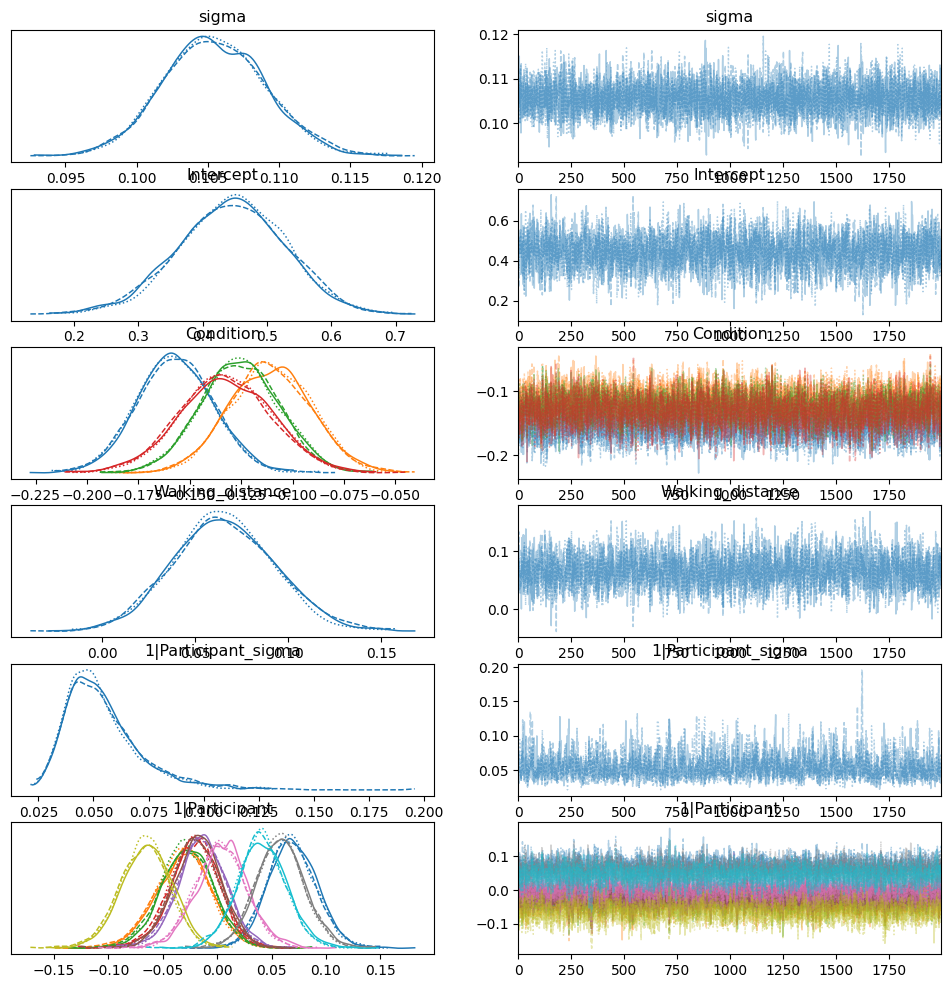

In [6]:

# Zusammenfassung der Posterior-Werte
print(az.summary(fitted))

# Posterior-Traces visualisieren
az.plot_trace(fitted)

# Diagnostik (Rhat-Werte überprüfen)
diagnostics = az.rhat(fitted)
print(diagnostics)

# Werte von Rhat sollten nahe 1 liegen (idealerweise < 1.05).


array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Condition\n2'}>],
       [<Axes: title={'center': 'Condition\n3'}>,
        <Axes: title={'center': 'Condition\n4'}>,
        <Axes: title={'center': 'Condition\n5'}>],
       [<Axes: title={'center': 'Walking_distance'}>,
        <Axes: title={'center': '1|Participant_sigma'}>,
        <Axes: title={'center': '1|Participant\n8'}>],
       [<Axes: title={'center': '1|Participant\n9'}>,
        <Axes: title={'center': '1|Participant\n10'}>,
        <Axes: title={'center': '1|Participant\n11'}>],
       [<Axes: title={'center': '1|Participant\n12'}>,
        <Axes: title={'center': '1|Participant\n13'}>,
        <Axes: title={'center': '1|Participant\n14'}>],
       [<Axes: title={'center': '1|Participant\n15'}>,
        <Axes: title={'center': '1|Participant\n16'}>,
        <Axes: title={'center': '1|Participant\n17'}>]], dtype=object)

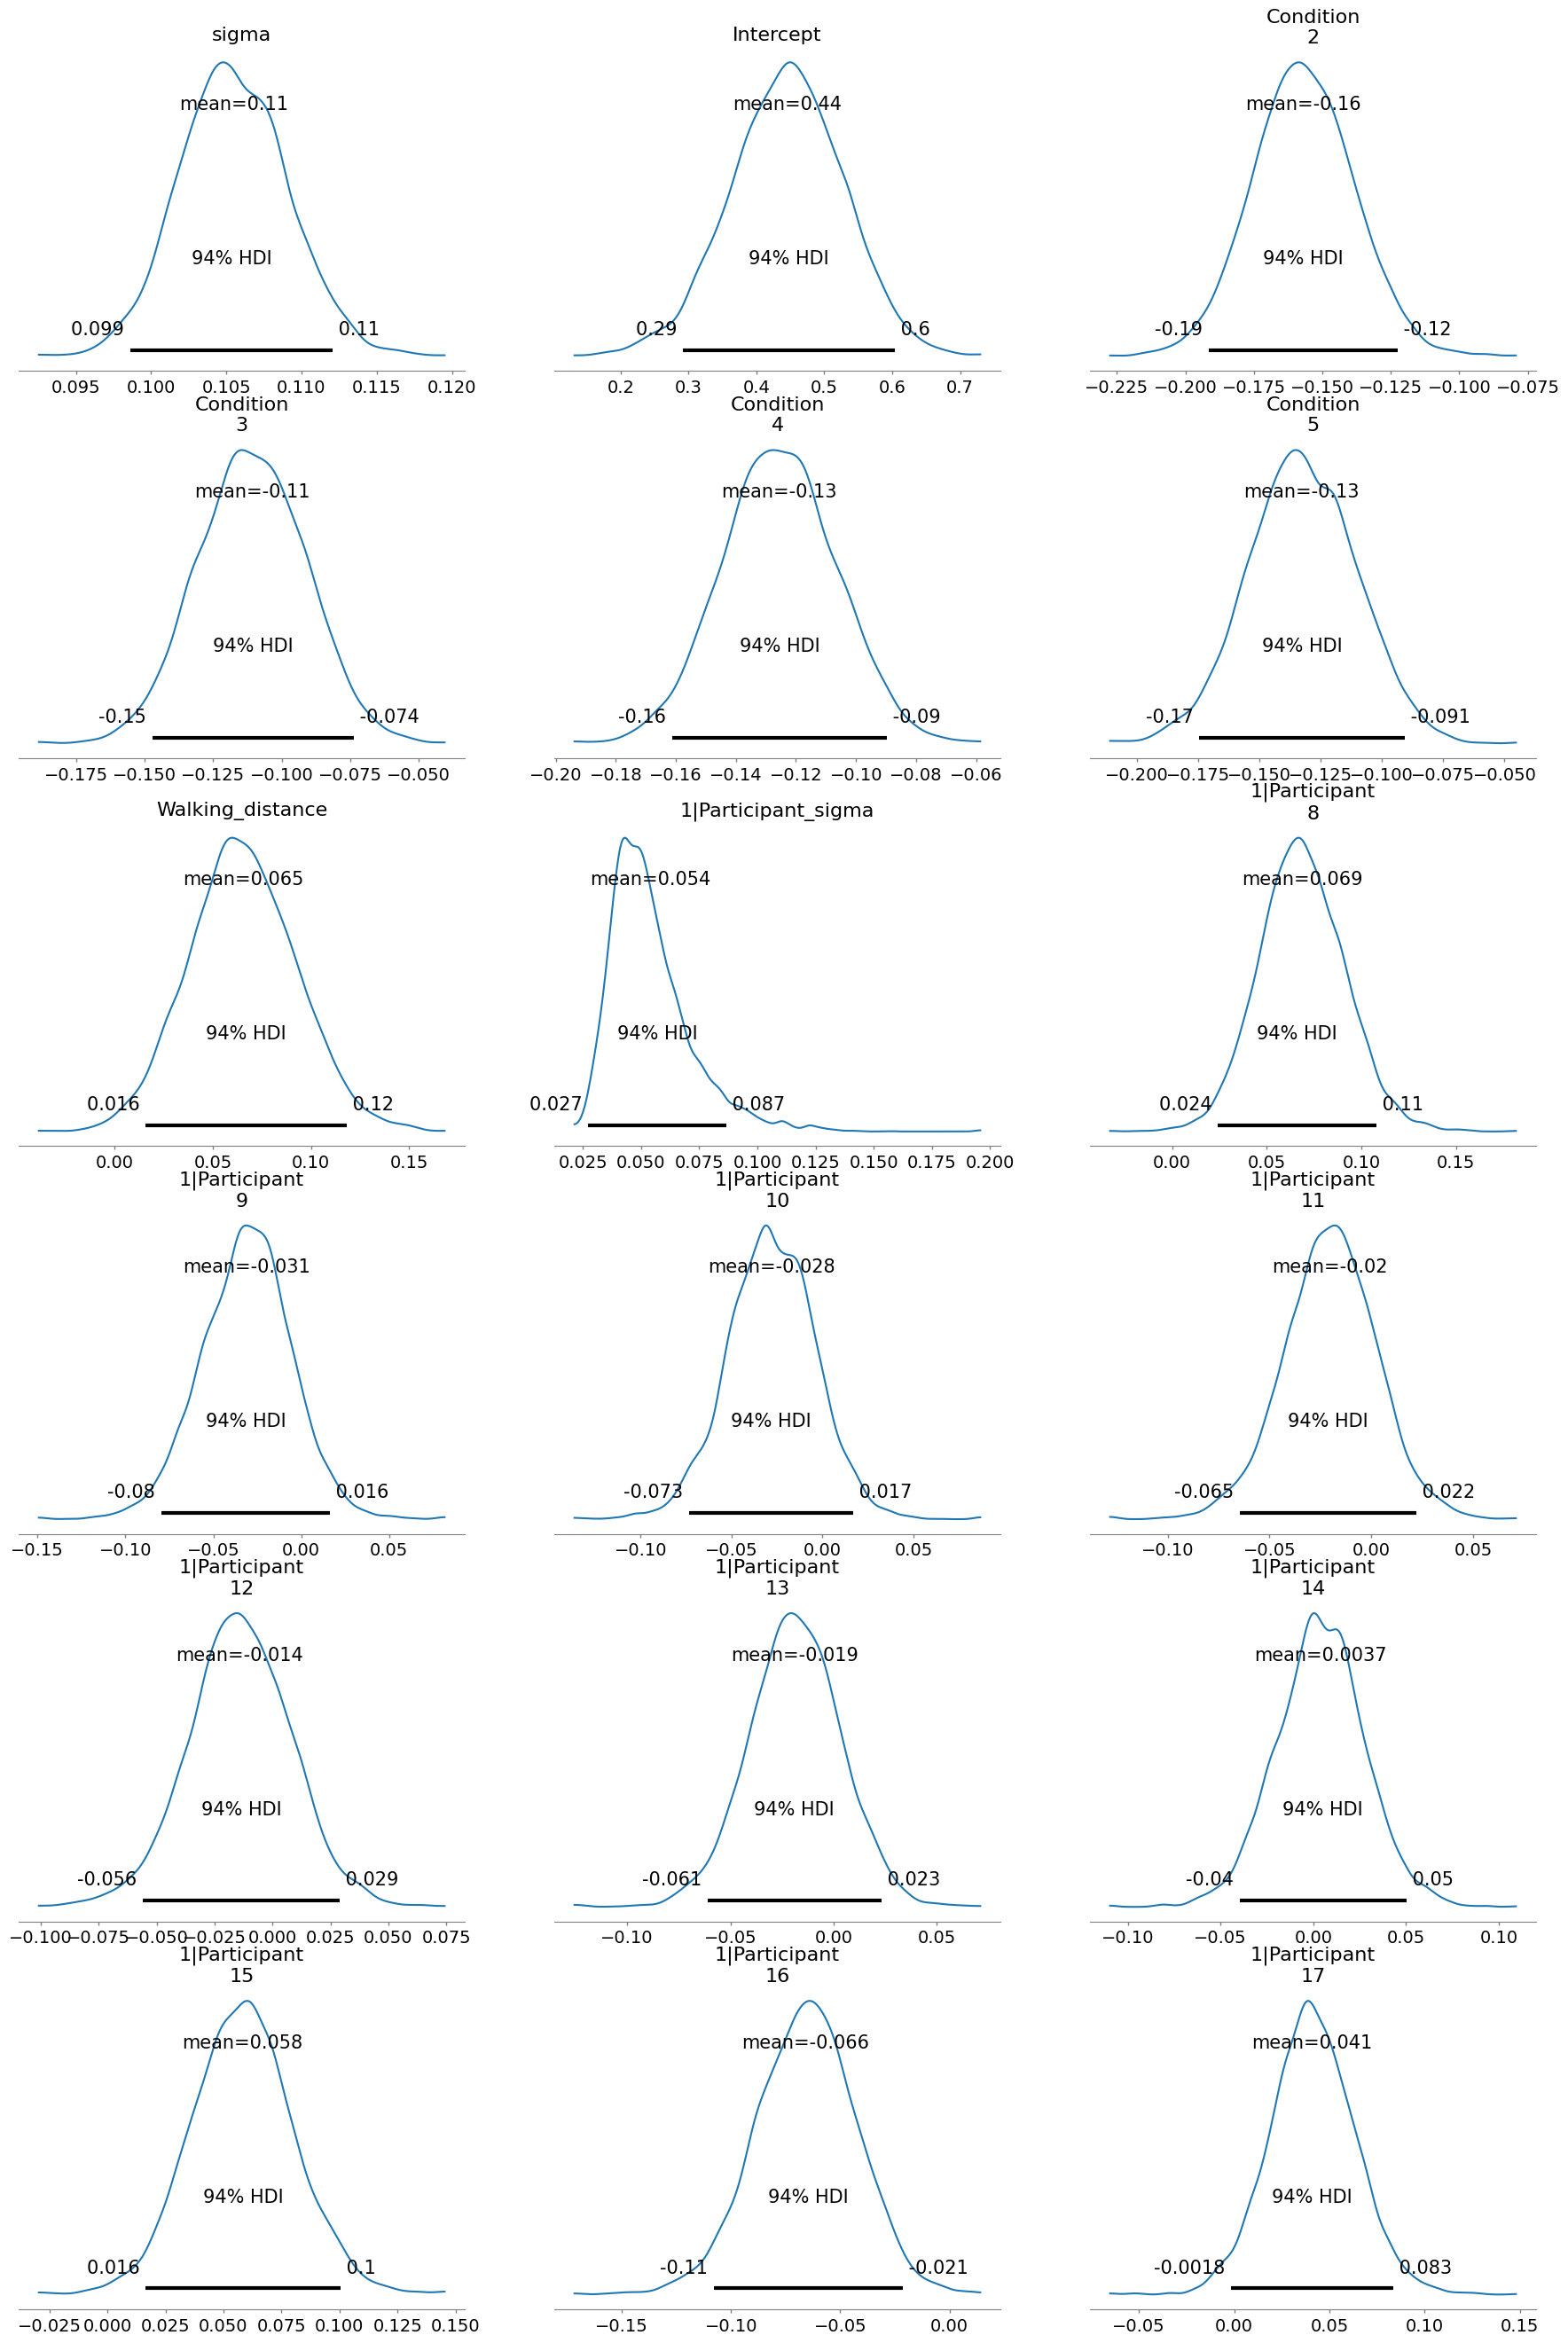

In [11]:
az.plot_posterior(fitted)

In [8]:
ppc = model.predict(idata=fitted, kind="pps", inplace=False)


c:\Users\grego\OneDrive\Dokumente\Uni\MasterThesis\Master_Thesis\.venv\lib\site-packages\bambi\models.py:858: FutureWarning: 'pps' has been replaced by 'response' and is not going to work in the future
  warnings.warn(


In [31]:
print(ppc)

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

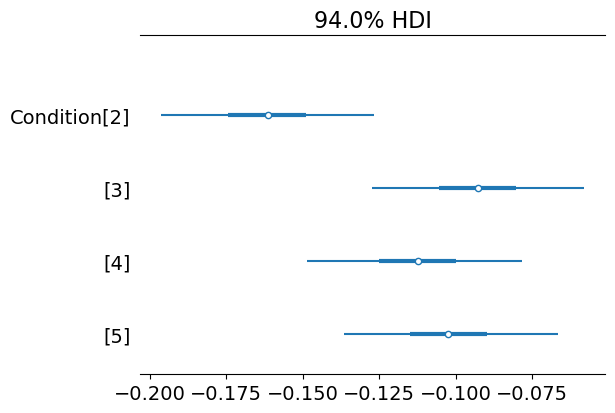

In [10]:

az.plot_forest(fitted, var_names=["Condition"], combined=True)

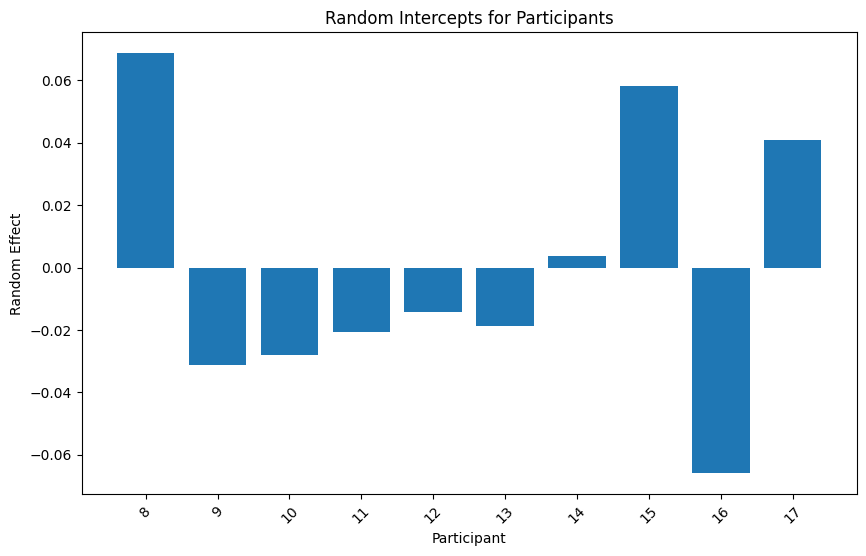

In [9]:
participant_effects = fitted.posterior["1|Participant"].mean(dim=["chain", "draw"])

# Konvertiere die Effekte in ein pandas DataFrame
participant_effects_df = pd.DataFrame({
    "Participant": participant_effects.Participant__factor_dim.values,
    "Effect": participant_effects.values
})

# Plot der zufälligen Effekte
plt.figure(figsize=(10, 6))
plt.bar(participant_effects_df["Participant"], participant_effects_df["Effect"])
plt.title("Random Intercepts for Participants")
plt.xlabel("Participant")
plt.ylabel("Random Effect")
plt.xticks(rotation=45)
plt.show()

<Axes: xlabel='Velocity'>

c:\Users\grego\OneDrive\Dokumente\Uni\MasterThesis\Master_Thesis\.venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\grego\OneDrive\Dokumente\Uni\MasterThesis\Master_Thesis\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


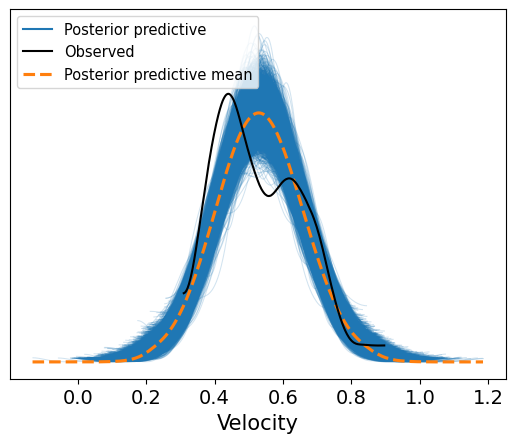

In [10]:
az.plot_ppc(ppc)

In [16]:

model_l = bmb.Model(
    "strideLength_l ~ Condition + Walking_distance + numStrides_l+ (1|Participant)", 
    data=df, 
    family="gaussian"
)

results_l = model_l.fit(draws=2000, tune=1000)

model_r = bmb.Model(
    "strideLength_r ~ Condition + Walking_distance + numStrides_r + (1|Participant)", 
    data=df, 
    family="gaussian"
)
results_r = model_r.fit(draws=2000, tune=1000)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, Intercept, Condition, Walking_distance, numStrides_l, 1|Participant_sigma, 1|Participant_offset]


Output()

Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 2912 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, Intercept, Condition, Walking_distance, numStrides_r, 1|Participant_sigma, 1|Participant_offset]


Output()

Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 3065 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'Condition'}>,
        <Axes: title={'center': 'Condition'}>],
       [<Axes: title={'center': 'Walking_distance'}>,
        <Axes: title={'center': 'Walking_distance'}>],
       [<Axes: title={'center': 'numStrides_r'}>,
        <Axes: title={'center': 'numStrides_r'}>],
       [<Axes: title={'center': '1|Participant_sigma'}>,
        <Axes: title={'center': '1|Participant_sigma'}>],
       [<Axes: title={'center': '1|Participant'}>,
        <Axes: title={'center': '1|Participant'}>]], dtype=object)

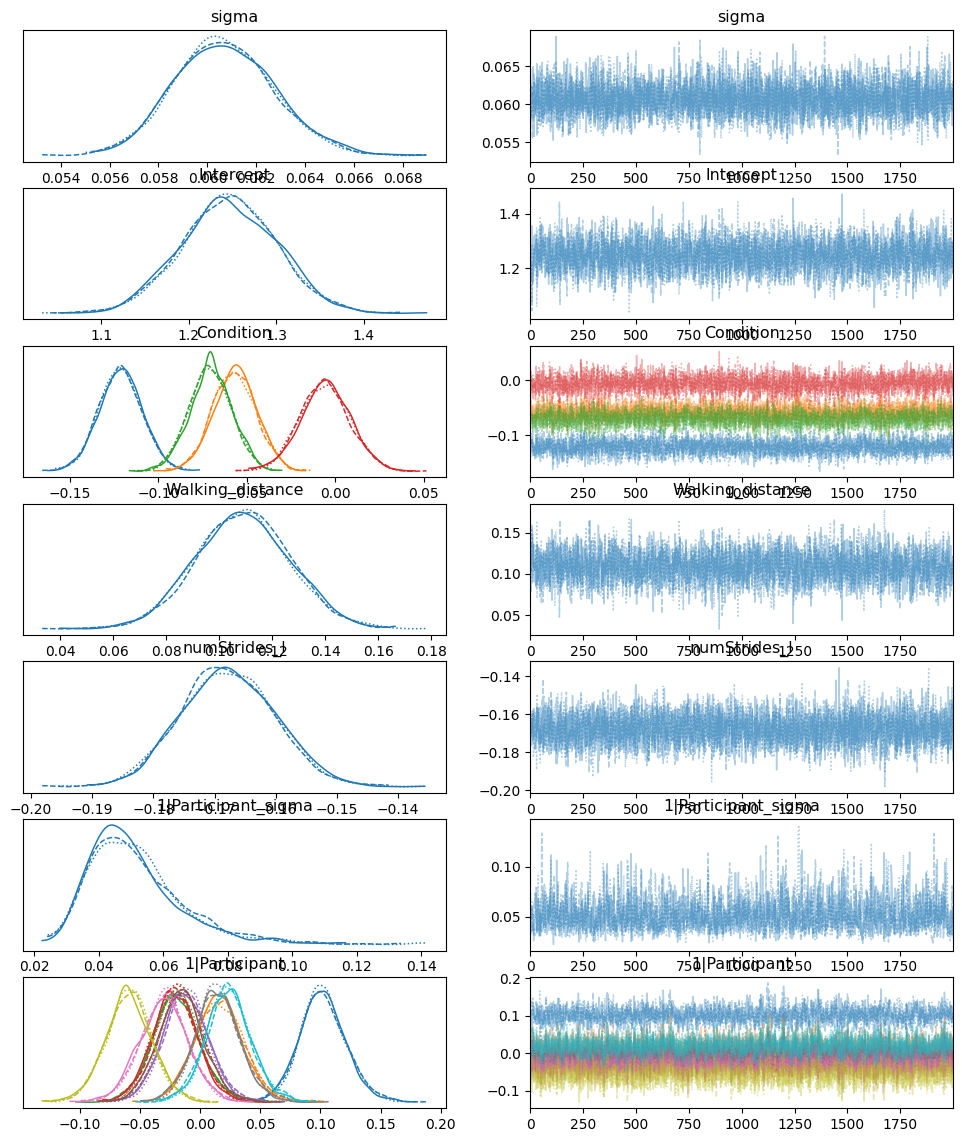

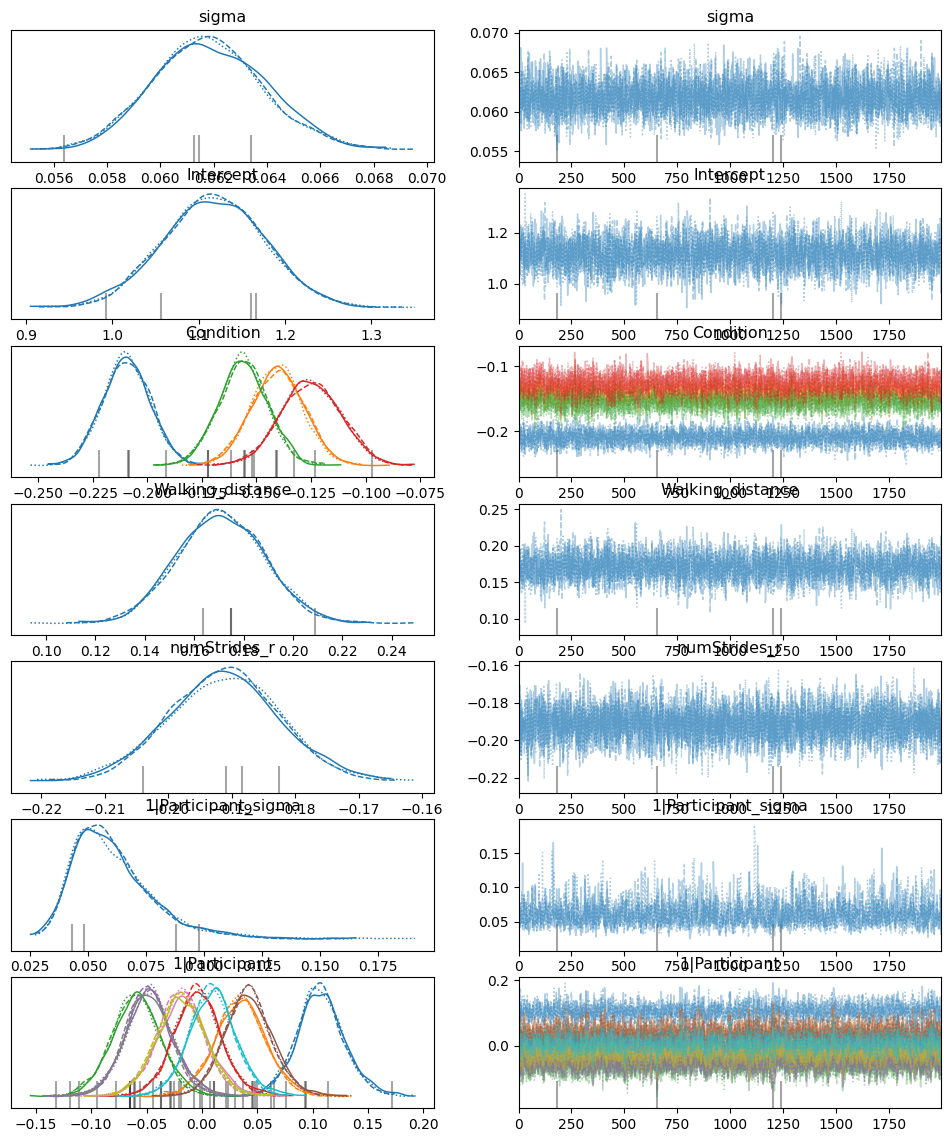

In [22]:
az.plot_trace(results_l)
az.plot_trace(results_r)

c:\Users\grego\OneDrive\Dokumente\Uni\MasterThesis\Master_Thesis\.venv\lib\site-packages\bambi\models.py:858: FutureWarning: 'pps' has been replaced by 'response' and is not going to work in the future
  warnings.warn(


<Axes: xlabel='strideLength_l'>

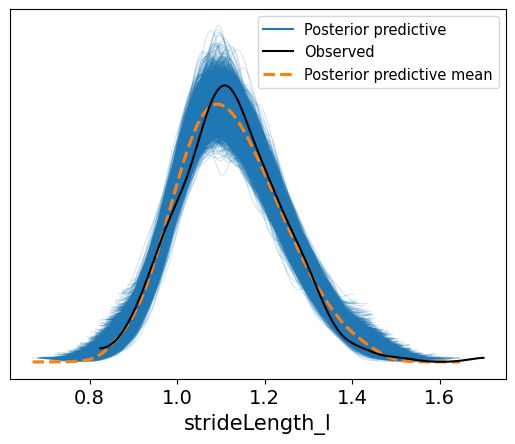

In [21]:
ppc_l = model_l.predict(idata=results_l, kind="pps", inplace=False)
az.plot_ppc(ppc_l)

c:\Users\grego\OneDrive\Dokumente\Uni\MasterThesis\Master_Thesis\.venv\lib\site-packages\bambi\models.py:858: FutureWarning: 'pps' has been replaced by 'response' and is not going to work in the future
  warnings.warn(


<Axes: xlabel='strideLength_r'>

c:\Users\grego\OneDrive\Dokumente\Uni\MasterThesis\Master_Thesis\.venv\lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\grego\OneDrive\Dokumente\Uni\MasterThesis\Master_Thesis\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


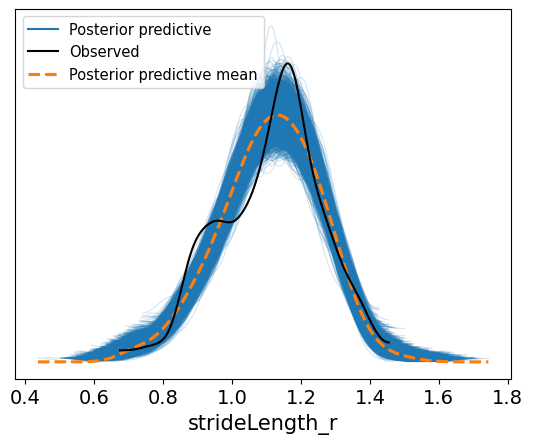

In [23]:
ppc_r = model_r.predict(idata=results_r, kind="pps", inplace=False)
az.plot_ppc(ppc_r)

c:\Users\grego\OneDrive\Dokumente\Uni\MasterThesis\Master_Thesis\.venv\lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: Walking_distance
Default computed for unspecified variable: Condition, Participant, numStrides_l


(<Figure size 640x480 with 1 Axes>,
 array([<Axes: xlabel='Walking_distance', ylabel='strideLength_l'>],
       dtype=object))

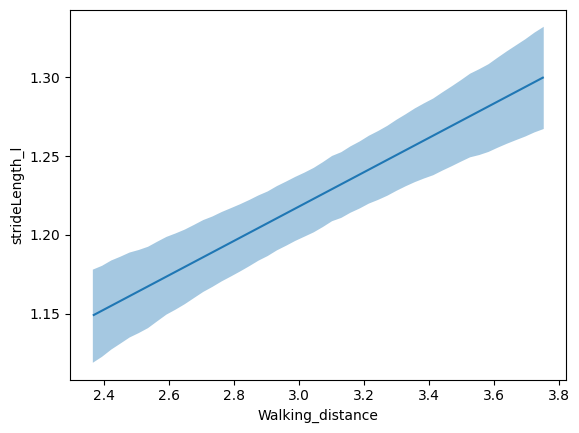

In [25]:
bmb.interpret.plot_predictions(model_l, results_l, "Walking_distance")